In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from typing import List, Optional, Tuple

import corner


In [2]:
from starccato_flow.data.toy_data import ToyData
from starccato_flow.data.ccsn_data import CCSNData
from starccato_flow.data.ccsn_snr_data import CCSNSNRData
from starccato_flow.training.trainer import Trainer

from starccato_flow.plotting.plotting import plot_reconstruction_distribution

/Users/tarineccleston/Desktop/starccato/starccato-flow/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/tarineccleston/Desktop/starccato/starccato-flow/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from starccato_flow.utils.defaults import DEVICE

### Dataset

In [4]:
# train_dataset = ToyData(num_signals=1684, signal_length=256)
# validation_dataset = ToyData(num_signals=round(1684 * 0.1), signal_length=256)

### Dataset Plots

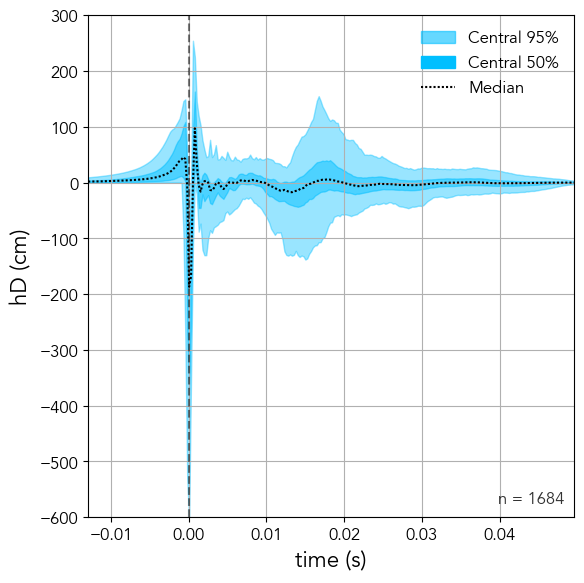

In [5]:
ccsn_dataset = CCSNData(noise=True, curriculum=True)
ccsn_dataset.plot_signal_distribution(background="white", font_family="sans-serif", font_name="Avenir", fname="plots/ccsn_signal_distribution.svg")

/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: divide by zero encountered in power
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: divide by zero encountered in divide
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: invalid value encountered in subtract
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))


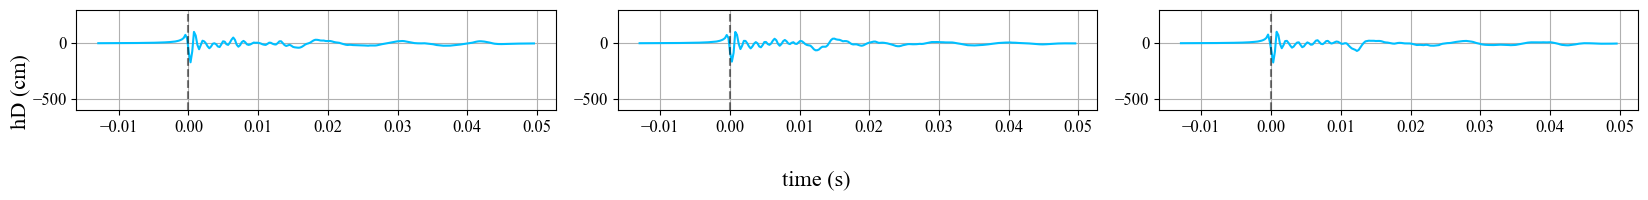

In [6]:
ccsn_dataset.plot_signal_grid(background="white", font_family="sans-serif", font_name="Avenir", fname="plots/ccsn_signal_grid.svg")

In [7]:
toy=False

### Train VAE + Flow


Verifying data alignment:
Number of signals: 1684
Number of parameter sets: 1684
Parameter columns: ['beta1_IC_b', 'A(km)', 'Ye_c_b', 'omega_0(rad|s)']
First few parameter values:
   beta1_IC_b  A(km)  Ye_c_b  omega_0(rad|s)
1    0.000749    634  0.2465             0.5
2    0.002987    634  0.2465             1.0
3    0.006661    634  0.2465             1.5
4    0.011734    634  0.2465             2.0
5    0.017965    634  0.2465             2.5

Verifying data alignment:
Number of signals: 1684
Number of parameter sets: 1684
Parameter columns: ['beta1_IC_b', 'A(km)', 'Ye_c_b', 'omega_0(rad|s)']
First few parameter values:
   beta1_IC_b  A(km)  Ye_c_b  omega_0(rad|s)
1    0.000749    634  0.2465             0.5
2    0.002987    634  0.2465             1.0
3    0.006661    634  0.2465             1.5
4    0.011734    634  0.2465             2.0
5    0.017965    634  0.2465             2.5
Training samples: 1516
Validation samples: 168


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: divide by zero encountered in power
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: divide by zero encountered in divide
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: invalid value encountered in subtract
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: divide by zero encountered in power
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 

Epoch 1/50 | Train Loss: 169.8943 | Val Loss: 86.4419


Epochs:   4%|▍         | 2/50 [00:07<02:45,  3.45s/it]

Epoch 2/50 | Train Loss: 69.6563 | Val Loss: 63.0357


Epochs:   6%|▌         | 3/50 [00:11<02:53,  3.68s/it]

Epoch 3/50 | Train Loss: 57.2332 | Val Loss: 55.4791


Epochs:   8%|▊         | 4/50 [00:14<02:40,  3.49s/it]

Epoch 4/50 | Train Loss: 51.6048 | Val Loss: 53.5593


Epochs:  10%|█         | 5/50 [00:16<02:23,  3.20s/it]

Epoch 5/50 | Train Loss: 48.5235 | Val Loss: 51.3598


Epochs:  12%|█▏        | 6/50 [00:19<02:15,  3.07s/it]

Epoch 6/50 | Train Loss: 46.3298 | Val Loss: 49.0475


Epochs:  14%|█▍        | 7/50 [00:23<02:18,  3.22s/it]

Epoch 7/50 | Train Loss: 44.9133 | Val Loss: 47.1554


Epochs:  16%|█▌        | 8/50 [00:26<02:20,  3.34s/it]

Epoch 8/50 | Train Loss: 43.6082 | Val Loss: 46.3129


Epochs:  18%|█▊        | 9/50 [00:30<02:17,  3.35s/it]

Epoch 9/50 | Train Loss: 42.4829 | Val Loss: 44.5628


Epochs:  20%|██        | 10/50 [00:34<02:21,  3.54s/it]

Epoch 10/50 | Train Loss: 41.1873 | Val Loss: 44.0888


Epochs:  22%|██▏       | 11/50 [00:37<02:17,  3.52s/it]

Epoch 11/50 | Train Loss: 40.8737 | Val Loss: 44.2047


Epochs:  24%|██▍       | 12/50 [00:40<02:09,  3.41s/it]

Epoch 12/50 | Train Loss: 39.6224 | Val Loss: 42.5473


Epochs:  26%|██▌       | 13/50 [00:43<02:00,  3.26s/it]

Epoch 13/50 | Train Loss: 38.7653 | Val Loss: 42.5562


Epochs:  28%|██▊       | 14/50 [00:46<01:53,  3.14s/it]

Epoch 14/50 | Train Loss: 38.2161 | Val Loss: 42.6489


Epochs:  30%|███       | 15/50 [00:49<01:44,  2.98s/it]

Epoch 15/50 | Train Loss: 37.6535 | Val Loss: 41.8996
Epoch 16/50 | Train Loss: 37.5578 | Val Loss: 41.5804
Generated signals shape: (32, 256)
Epoch 16/50 | Train Loss: 37.5578 | Val Loss: 41.5804
Generated signals shape: (32, 256)


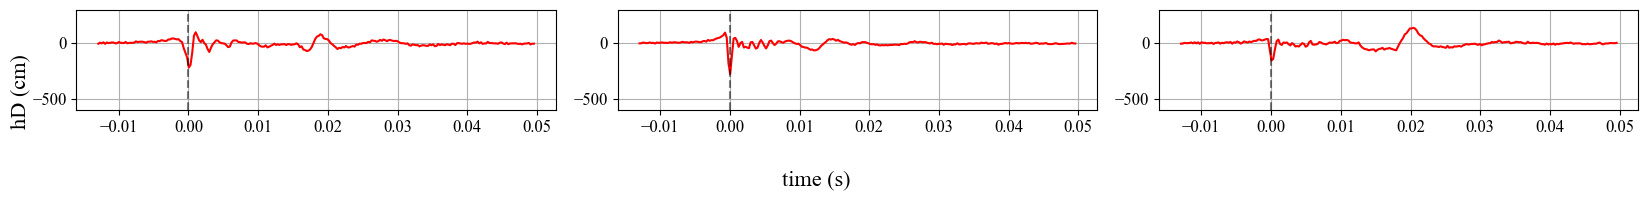

/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: divide by zero encountered in power
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: divide by zero encountered in divide
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: invalid value encountered in subtract
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))


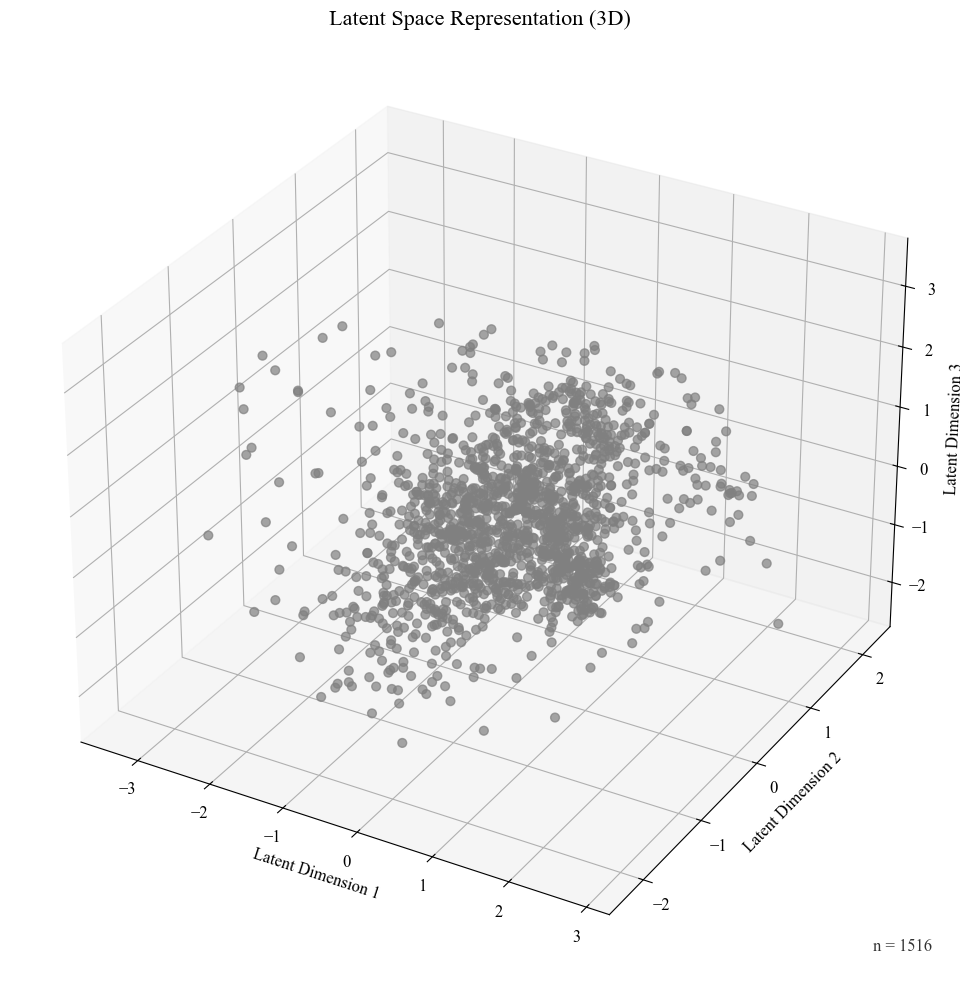

Epochs:  32%|███▏      | 16/50 [00:55<02:17,  4.06s/it]/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: divide by zero encountered in power
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: divide by zero encountered in divide
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: invalid value encountered in subtract
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: divide by zero encountered in power
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * 

Epoch 17/50 | Train Loss: 37.4511 | Val Loss: 41.3994


Epochs:  36%|███▌      | 18/50 [01:05<02:16,  4.28s/it]

Epoch 18/50 | Train Loss: 36.7136 | Val Loss: 41.5782


Epochs:  38%|███▊      | 19/50 [01:08<01:56,  3.74s/it]

Epoch 19/50 | Train Loss: 36.4547 | Val Loss: 41.1110


Epochs:  40%|████      | 20/50 [01:10<01:42,  3.42s/it]

Epoch 20/50 | Train Loss: 36.4981 | Val Loss: 39.3180


Epochs:  42%|████▏     | 21/50 [01:14<01:41,  3.51s/it]

Epoch 21/50 | Train Loss: 36.1592 | Val Loss: 41.4047


Epochs:  44%|████▍     | 22/50 [01:19<01:52,  4.03s/it]

Epoch 22/50 | Train Loss: 35.7892 | Val Loss: 39.3913


Epochs:  46%|████▌     | 23/50 [01:23<01:43,  3.84s/it]

Epoch 23/50 | Train Loss: 35.5954 | Val Loss: 40.0046


Epochs:  48%|████▊     | 24/50 [01:25<01:31,  3.54s/it]

Epoch 24/50 | Train Loss: 35.2918 | Val Loss: 39.3494


Epochs:  50%|█████     | 25/50 [01:28<01:23,  3.33s/it]

Epoch 25/50 | Train Loss: 35.3290 | Val Loss: 39.6769


Epochs:  52%|█████▏    | 26/50 [01:31<01:18,  3.29s/it]

Epoch 26/50 | Train Loss: 34.8243 | Val Loss: 39.0354


Epochs:  54%|█████▍    | 27/50 [01:35<01:19,  3.47s/it]

Epoch 27/50 | Train Loss: 34.7711 | Val Loss: 38.8601


Epochs:  56%|█████▌    | 28/50 [01:39<01:16,  3.46s/it]

Epoch 28/50 | Train Loss: 34.8936 | Val Loss: 40.3294


Epochs:  58%|█████▊    | 29/50 [01:42<01:11,  3.39s/it]

Epoch 29/50 | Train Loss: 34.5225 | Val Loss: 38.4177


Epochs:  60%|██████    | 30/50 [01:45<01:05,  3.29s/it]

Epoch 30/50 | Train Loss: 34.2353 | Val Loss: 38.5607


Epochs:  62%|██████▏   | 31/50 [01:48<01:01,  3.24s/it]

Epoch 31/50 | Train Loss: 34.2827 | Val Loss: 39.0975
Epoch 32/50 | Train Loss: 33.8554 | Val Loss: 39.4744
Generated signals shape: (32, 256)
Epoch 32/50 | Train Loss: 33.8554 | Val Loss: 39.4744
Generated signals shape: (32, 256)


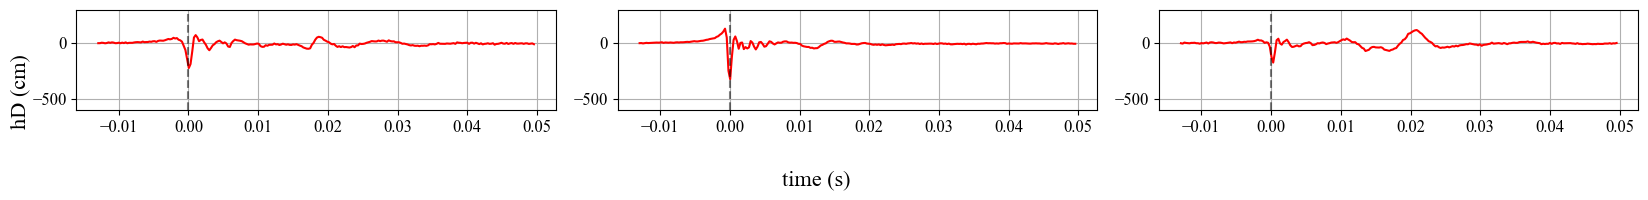

/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: divide by zero encountered in power
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: divide by zero encountered in divide
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: invalid value encountered in subtract
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))


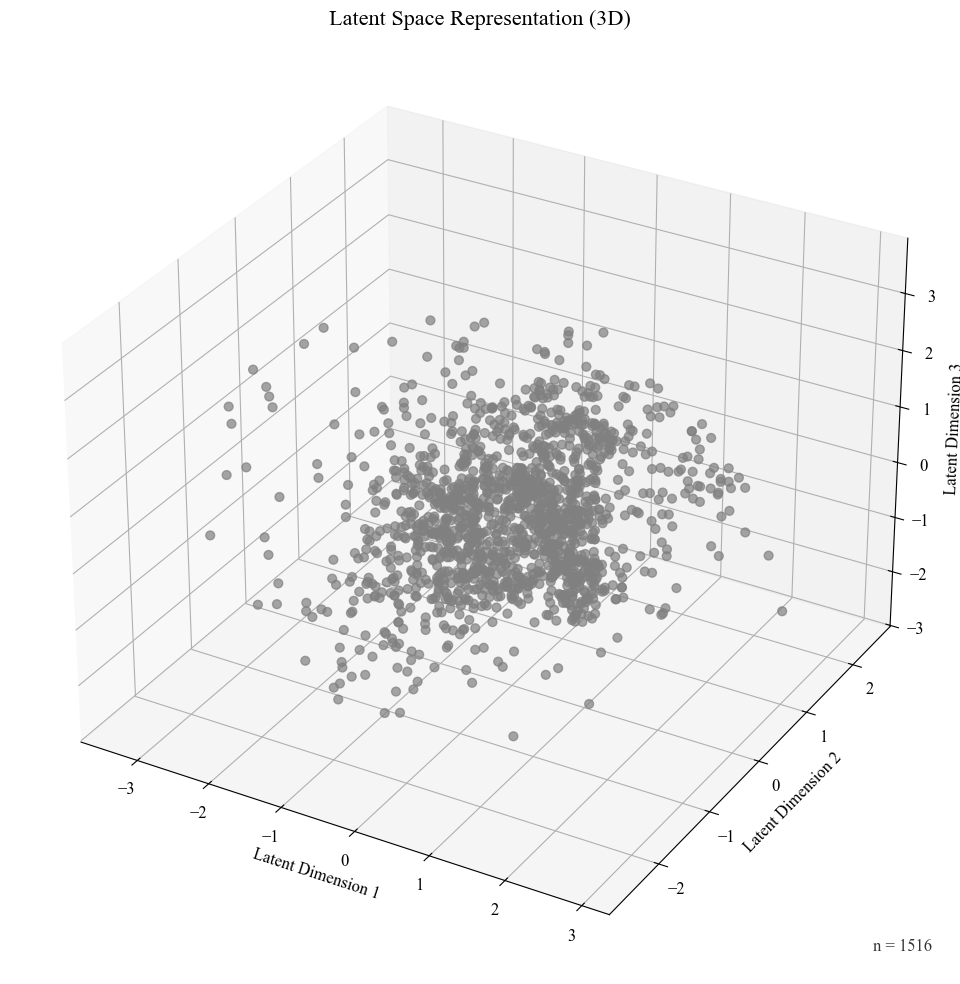

Epochs:  64%|██████▍   | 32/50 [01:56<01:21,  4.53s/it]/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: divide by zero encountered in power
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: divide by zero encountered in divide
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: invalid value encountered in subtract
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: divide by zero encountered in power
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * 

Epoch 33/50 | Train Loss: 33.9100 | Val Loss: 38.9823


Epochs:  68%|██████▊   | 34/50 [02:05<01:12,  4.52s/it]

Epoch 34/50 | Train Loss: 33.9850 | Val Loss: 37.8366


Epochs:  70%|███████   | 35/50 [02:08<00:58,  3.89s/it]

Epoch 35/50 | Train Loss: 33.7582 | Val Loss: 38.9325


Epochs:  72%|███████▏  | 36/50 [02:10<00:49,  3.52s/it]

Epoch 36/50 | Train Loss: 33.6798 | Val Loss: 38.5063


Epochs:  74%|███████▍  | 37/50 [02:14<00:44,  3.42s/it]

Epoch 37/50 | Train Loss: 33.5221 | Val Loss: 37.6562


Epochs:  76%|███████▌  | 38/50 [02:17<00:40,  3.38s/it]

Epoch 38/50 | Train Loss: 33.5182 | Val Loss: 38.0824


Epochs:  78%|███████▊  | 39/50 [02:20<00:36,  3.28s/it]

Epoch 39/50 | Train Loss: 33.3996 | Val Loss: 37.9451


Epochs:  80%|████████  | 40/50 [02:23<00:33,  3.31s/it]

Epoch 40/50 | Train Loss: 33.5543 | Val Loss: 38.1726


Epochs:  82%|████████▏ | 41/50 [02:27<00:31,  3.45s/it]

Epoch 41/50 | Train Loss: 33.7256 | Val Loss: 40.0291


Epochs:  84%|████████▍ | 42/50 [02:31<00:28,  3.61s/it]

Epoch 42/50 | Train Loss: 33.1410 | Val Loss: 37.7877


Epochs:  86%|████████▌ | 43/50 [02:35<00:24,  3.56s/it]

Epoch 43/50 | Train Loss: 32.7122 | Val Loss: 38.7304


Epochs:  88%|████████▊ | 44/50 [02:41<00:26,  4.44s/it]

Epoch 44/50 | Train Loss: 33.0212 | Val Loss: 39.3702


Epochs:  90%|█████████ | 45/50 [02:43<00:18,  3.78s/it]

Epoch 45/50 | Train Loss: 32.7818 | Val Loss: 37.4774


Epochs:  92%|█████████▏| 46/50 [02:46<00:13,  3.36s/it]

Epoch 46/50 | Train Loss: 32.9630 | Val Loss: 38.3150


Epochs:  94%|█████████▍| 47/50 [02:48<00:09,  3.05s/it]

Epoch 47/50 | Train Loss: 32.8190 | Val Loss: 38.7137
Epoch 48/50 | Train Loss: 32.6006 | Val Loss: 38.1583
Generated signals shape: (32, 256)
Epoch 48/50 | Train Loss: 32.6006 | Val Loss: 38.1583
Generated signals shape: (32, 256)


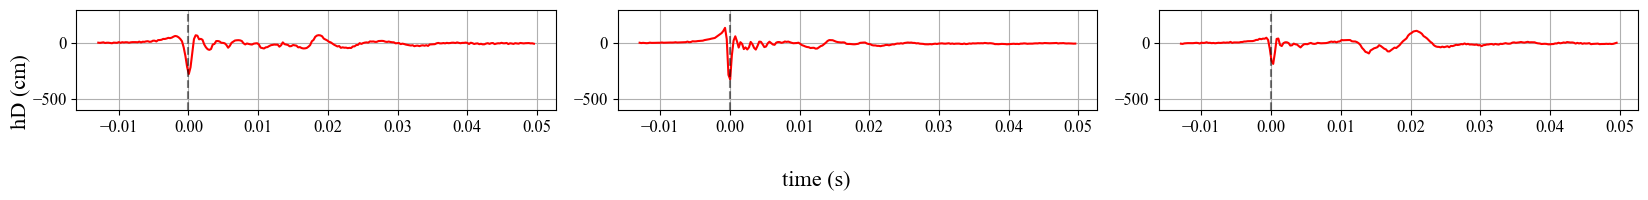

/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: divide by zero encountered in power
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: divide by zero encountered in divide
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: invalid value encountered in subtract
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))


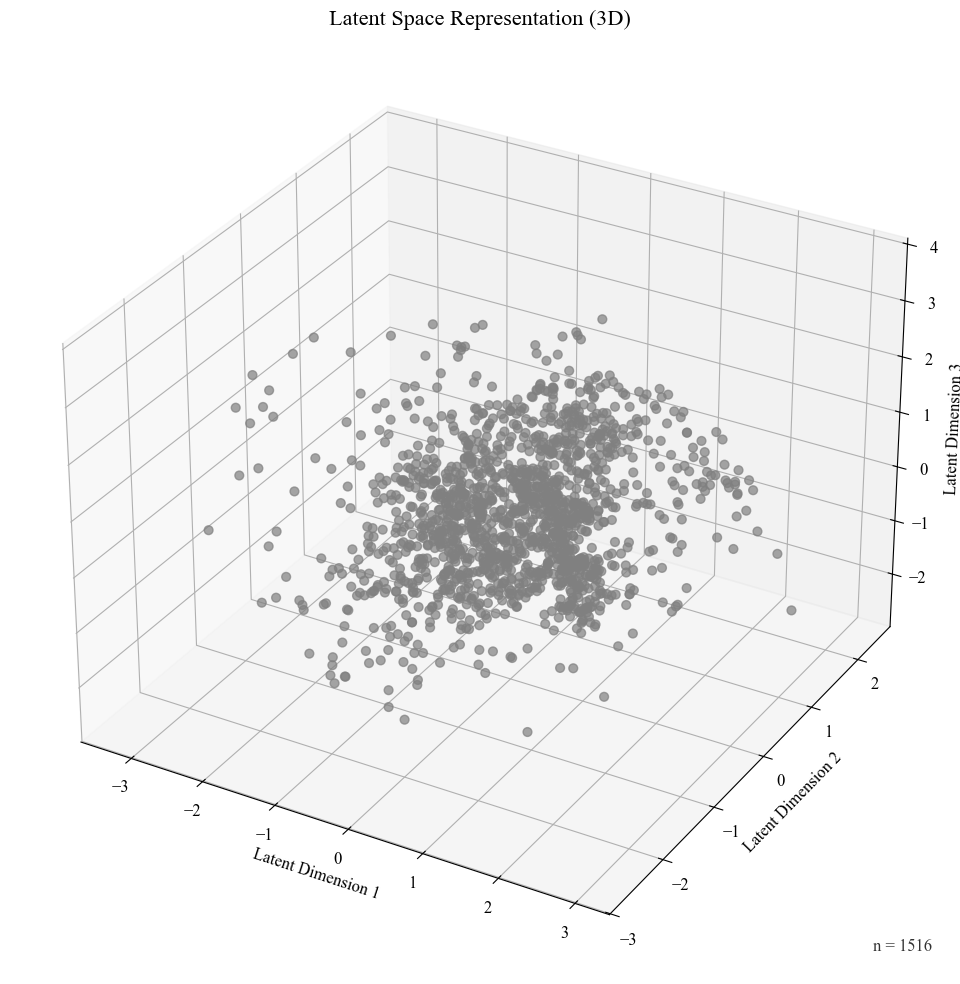

Epochs:  96%|█████████▌| 48/50 [02:52<00:06,  3.46s/it]/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: divide by zero encountered in power
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: divide by zero encountered in divide
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: invalid value encountered in subtract
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: divide by zero encountered in power
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * 

Epoch 49/50 | Train Loss: 32.5170 | Val Loss: 38.5330


Epochs: 100%|██████████| 50/50 [02:57<00:00,  3.55s/it]

Epoch 50/50 | Train Loss: 32.7098 | Val Loss: 36.9920
Training Time: 2.96min
Saved VAE model to outdir/generator_weights.pt

Starting Flow Training with Regularization & Early Stopping


56.038634300231934 168
Epoch [1/500] | Flow Train NLL: 11.2384 | Val NLL: 0.3336 ✓ (Best)
41.02617359161377 168
Epoch [2/500] | Flow Train NLL: 8.0434 | Val NLL: 0.2442 ✓ (Best)
41.02617359161377 168
Epoch [2/500] | Flow Train NLL: 8.0434 | Val NLL: 0.2442 ✓ (Best)
30.121907234191895 168
Epoch [3/500] | Flow Train NLL: 5.9248 | Val NLL: 0.1793 ✓ (Best)
30.121907234191895 168
Epoch [3/500] | Flow Train NLL: 5.9248 | Val NLL: 0.1793 ✓ (Best)
22.40531611442566 168
Epoch [4/500] | Flow Train NLL: 4.3672 | Val NLL: 0.1334 ✓ (Best)
22.40531611442566 168
Epoch [4/500] | Flow Train NLL: 4.3672 | Val NLL: 0.1334 ✓ (Best)
17.5974702835083 168
Epoch [5/500] | Flow Train NLL: 3.2854 | Val NLL: 0.1047 ✓ (Best)
17.5974702835083 168
Epoch [5/500] | Flow Train NLL: 3.2854 | Val NLL: 0.1047 ✓ (Best)
14.009923696517944 168
Epoch [6/500] | Flow Train NLL: 2.6667 | Val NLL: 0.0834 ✓ (Best)
14.009923696517944 168
Epoch [6/500] | Flow Train NLL: 2.6667 | Val NLL: 0.0834 ✓ (Best)
13.928502321243286 168
Epoch

In [8]:
trainer = Trainer(toy=toy, noise=True, curriculum=True)
trainer.train()

### Display Results

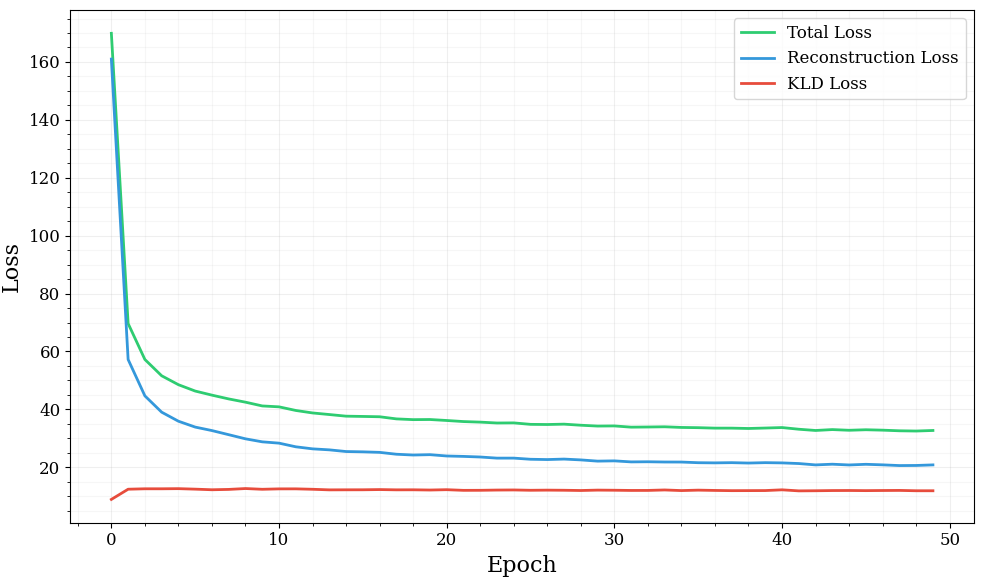

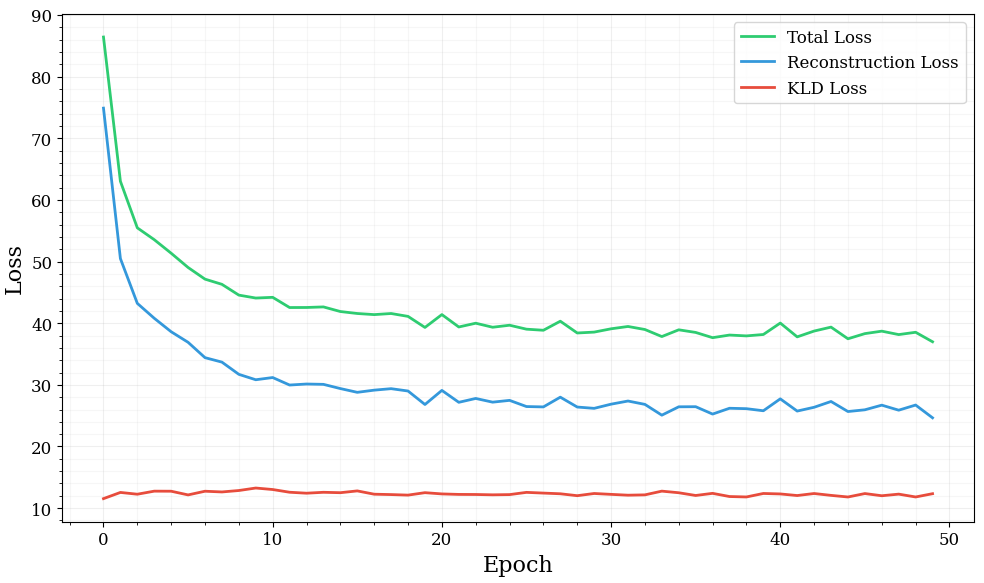

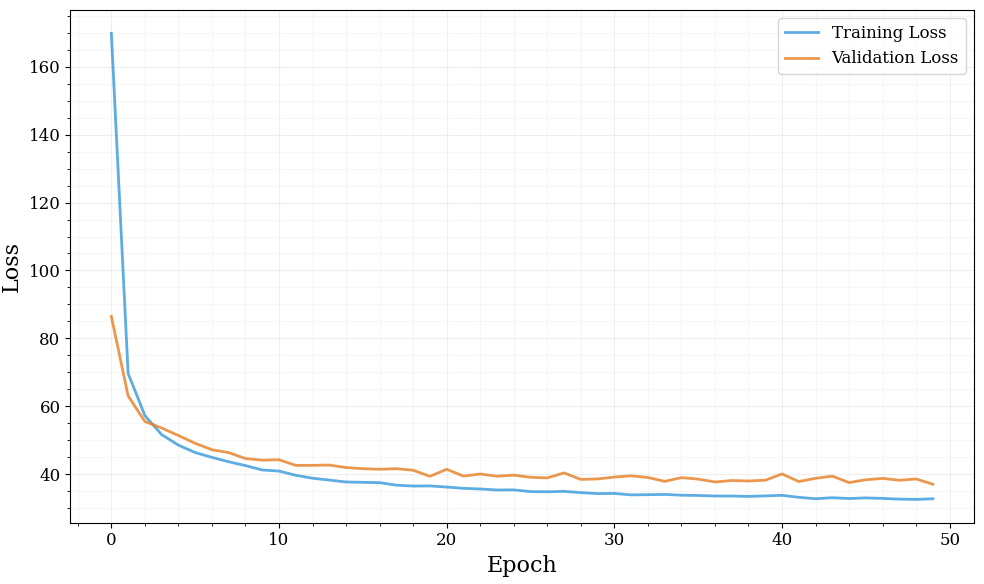

In [9]:
trainer.display_results()

In [10]:
# plot_latent_morph_up_and_down(
#     trainer.vae,
#     signal_1=ccsn_dataset.__getitem__(800)[0],
#     signal_2=ccsn_dataset.__getitem__(600)[0],
#     max_value=trainer.training_dataset.max_strain,
#     train_dataset=CCSNData(),
#     steps=1
# )

Execution Time: 0.25734925270080566 seconds


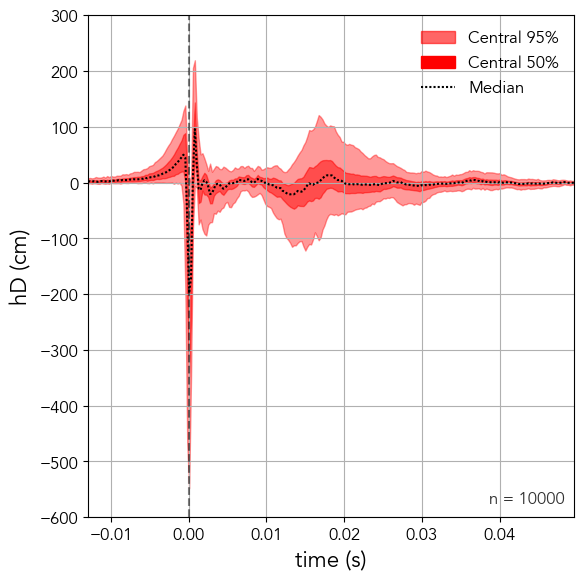

In [11]:
trainer.plot_generated_signal_distribution(
    background="white",
    font_family="sans-serif",
    font_name="Avenir"
)

/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: divide by zero encountered in power
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: divide by zero encountered in divide
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: invalid value encountered in subtract
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))


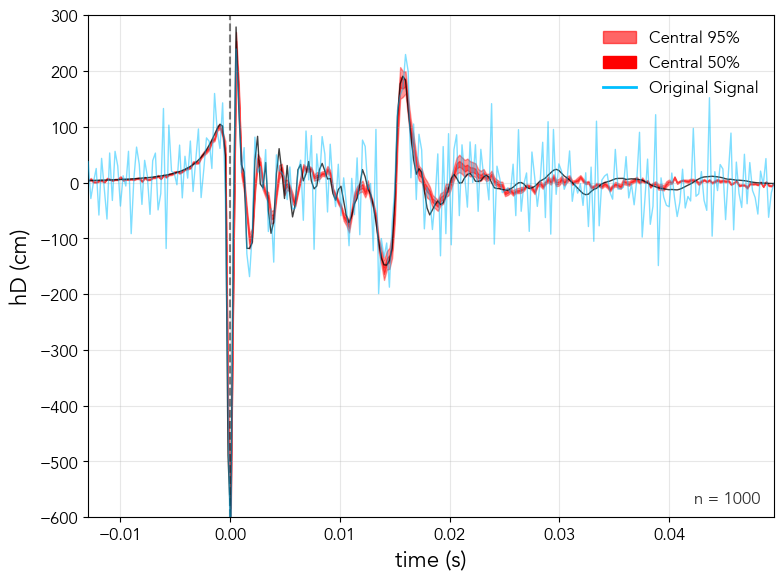

In [12]:
index = 1

val_idx = trainer.validation_sampler.indices[index]
signal, noisy_signal, params = trainer.val_loader.dataset.__getitem__(val_idx)

plot_reconstruction_distribution(
    vae=trainer.vae,
    noisy_signal=noisy_signal,
    true_signal=signal,
    max_value=trainer.validation_dataset.max_strain,
    num_samples=1000,
    background="white",
    font_family="sans-serif",
    font_name="Avenir"
)

In [13]:
trainer.save_models()

Saved VAE model to outdir/generator_weights.pt


/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: divide by zero encountered in power
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: divide by zero encountered in divide
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:338: RuntimeWarning: invalid value encountered in subtract
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))


True params: tensor([0.1021, 5.7038, 0.2779, 9.0000])
[0.10210583 5.7037826  0.27791956 9.        ]


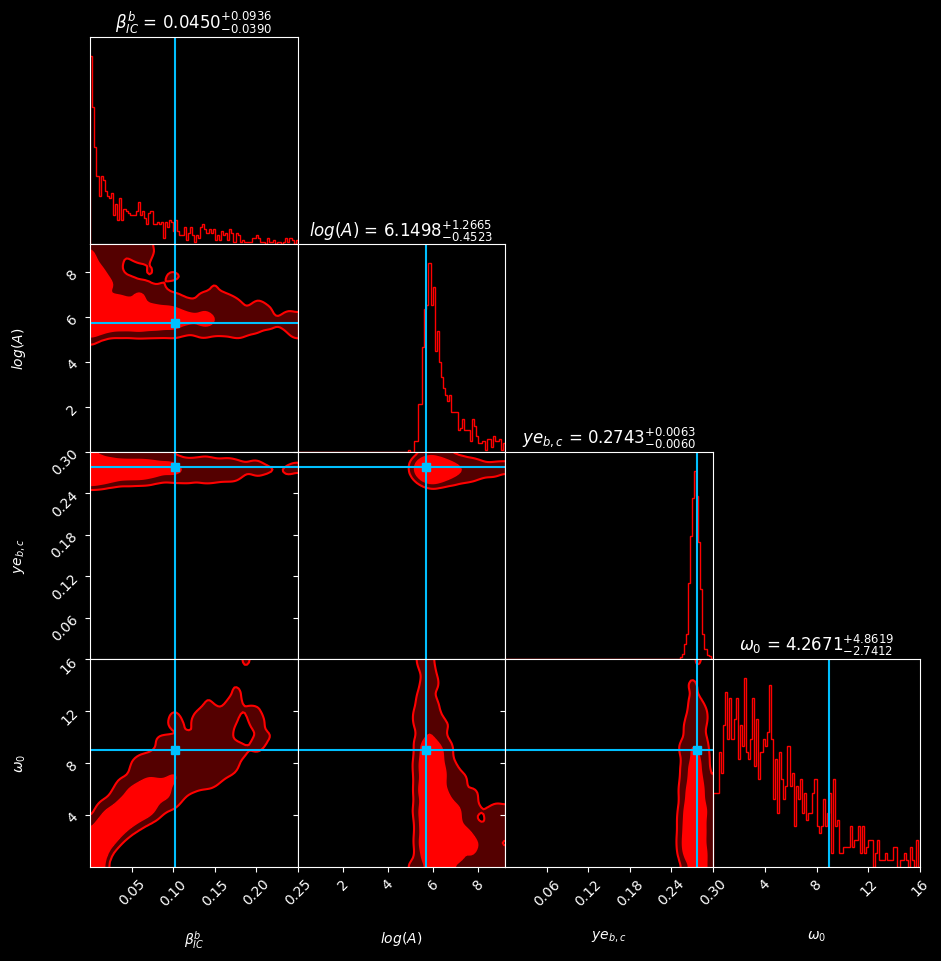

In [29]:
trainer.plot_corner(index=110)